In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
conn = sqlite3.connect('./sqlite/fire_incidents.sqlite')
common_points_threshold = 60000

def frame_for(field):
    frame = pd.read_sql_query("select " + field + ", PROP_LOSS from incidents where PROP_LOSS IS NOT NULL AND PROP_LOSS > 0", conn)
    frame[['PROP_LOSS']] = frame[['PROP_LOSS']].apply(pd.to_numeric)
    return frame

def plots_for(frame, field):
    common_data_frame = frame[frame.PROP_LOSS < common_points_threshold]
    common_data_frame.boxplot(column="PROP_LOSS", by=field, figsize=(15,9))

# Features for NFIRS property loss

Each feature under consideration will be shown with outliers removed because they skew heavily.

### Property Loss Distribution

We should start by just having a look at the overall shape of where property damage distributes out

Axes(0.125,0.125;0.775x0.775)


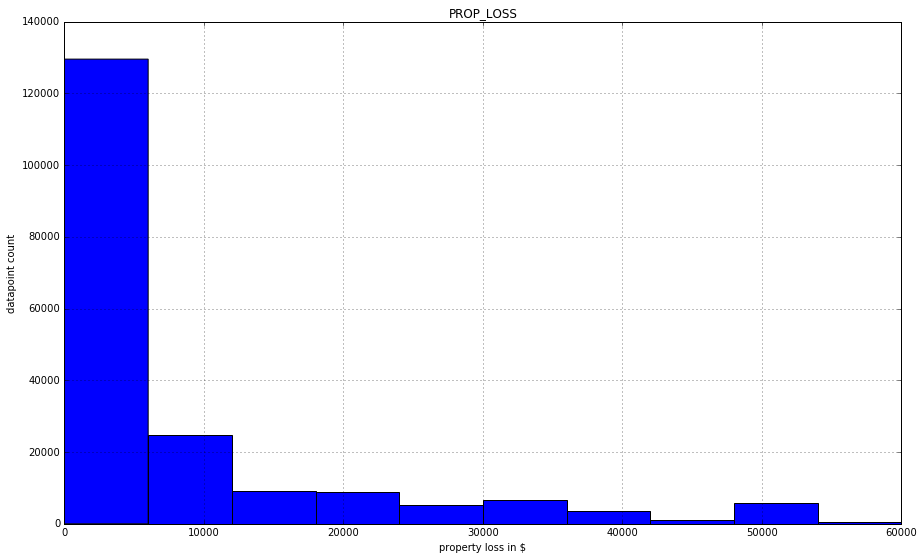

In [10]:
query = "select PROP_LOSS from incidents where PROP_LOSS IS NOT NULL AND PROP_LOSS > 0"

frame = pd.read_sql_query(query, conn)
frame[['PROP_LOSS']] = frame[['PROP_LOSS']].apply(pd.to_numeric)
common_data_frame = frame[frame.PROP_LOSS < common_points_threshold]

ret = common_data_frame.hist(column="PROP_LOSS", figsize=(15,9))
ax = ret[0][0]
ax.set_xlabel("property loss in $")
ax.set_ylabel("datapoint count")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


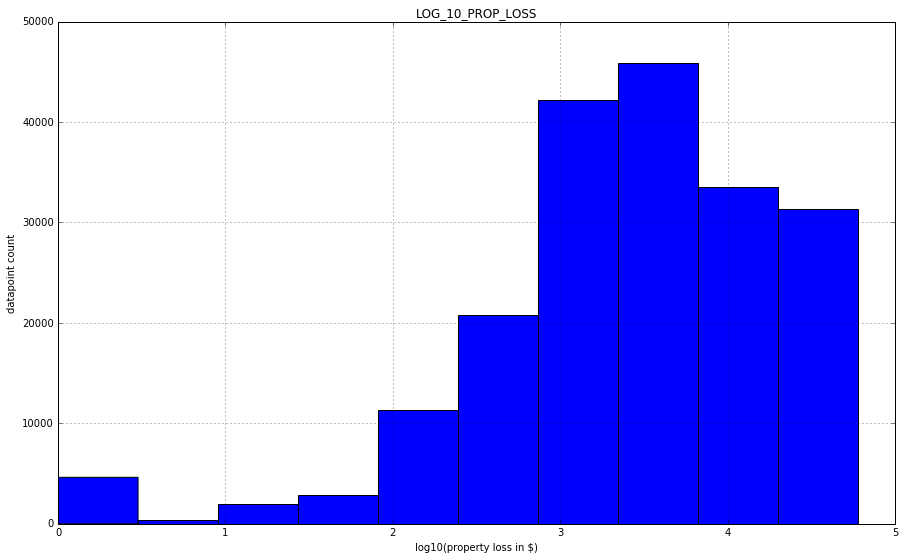

In [13]:
import math
common_data_frame['LOG_10_PROP_LOSS'] = common_data_frame['PROP_LOSS'].map(lambda x: math.log10(x))
ret = common_data_frame.hist(column="LOG_10_PROP_LOSS", figsize=(15,9))
ax = ret[0][0]
ax.set_xlabel("log10(property loss in $)")
ax.set_ylabel("datapoint count")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


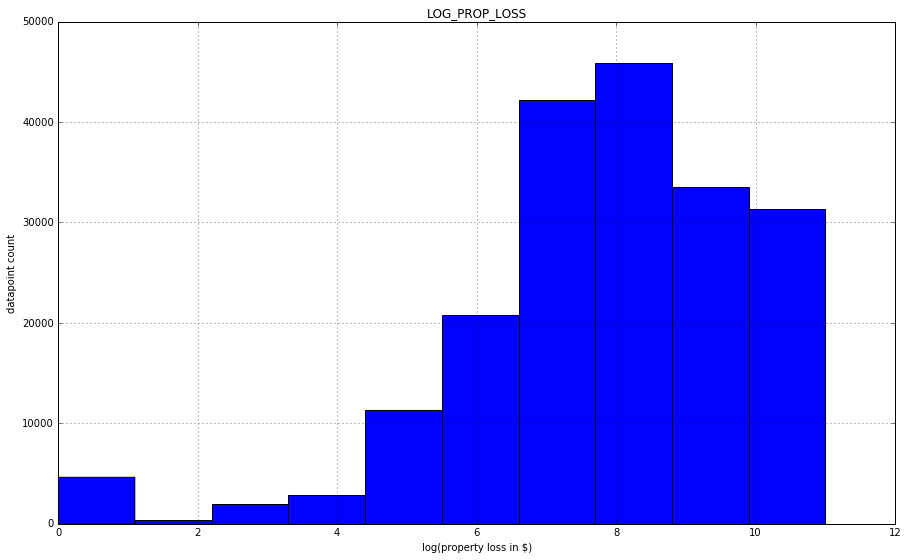

In [14]:
common_data_frame['LOG_PROP_LOSS'] = common_data_frame['PROP_LOSS'].map(lambda x: math.log(x))
ret = common_data_frame.hist(column="LOG_PROP_LOSS", figsize=(15,9))
ax = ret[0][0]
ax.set_xlabel("log(property loss in $)")
ax.set_ylabel("datapoint count")

It seems like the data is very heavily skewed, and that we'll end up with a better regression if we use the log of the target data rather than it's raw value.



### State
I expect State will be interesting because some states like California or New York will likely have high residential values for homes on average, but states like Arkansas and Missouri will have comparatively low real estate values.  Let's see if the box plots for property loss by state are interesting.

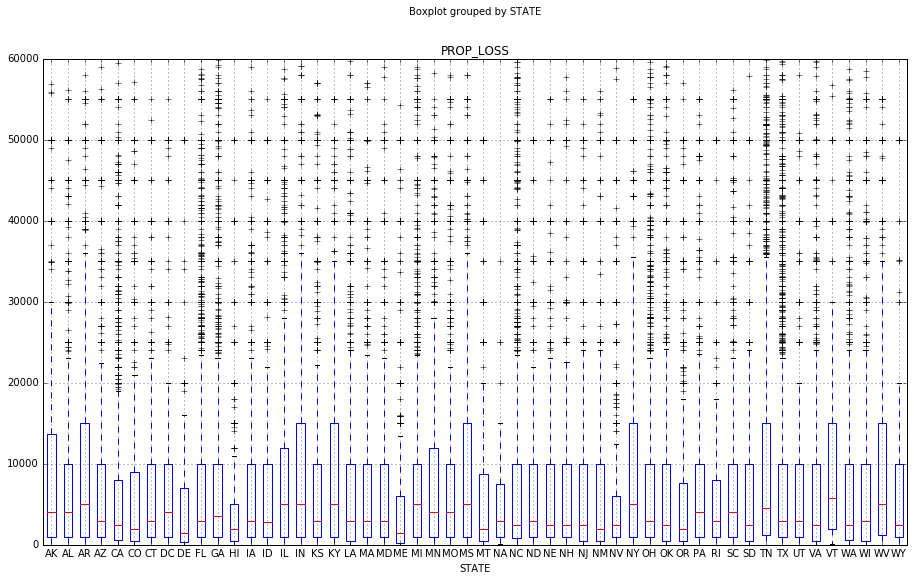

In [4]:
state_frame = frame_for('STATE')
plots_for(state_frame, 'STATE')

There is certainly some variation here.  AK, AR, VT, etc are noticable states with higher loss values, but I'm not convinced it's _very_ useful yet.  I might include it, by I'll probably need to reduce them to expensive states, middle of the road states, and cheap states so that we aren't adding 50 dimensions here.

### Incident Type
The next few columns I don't think are worth exploring.  the ID of the fire department, the date, the sequential number, NFIRS version, and station number; I'd have a hard time tying a reasonable relationship to any of those.  Incident type, though, may have promise.  Unfortunately, there are 66 unique values in the dataset.  That doesn't seem great as is, being able to group them would be useful.  There are some natural groupings that NFIRS provides in their heirarchical coding, but the grouping isn't really symetrical.  Some of the divisions inside the "100" groups are relevant (building fire vs vehical fire vs rubbish fire), but we can probably safely group anything in the 400s, 500s, or 600s together for the purposes of this analysis.  I think for anything with a "1" at the front we'll group by the second digit, but anything with >1 will be grouped by the first digit.

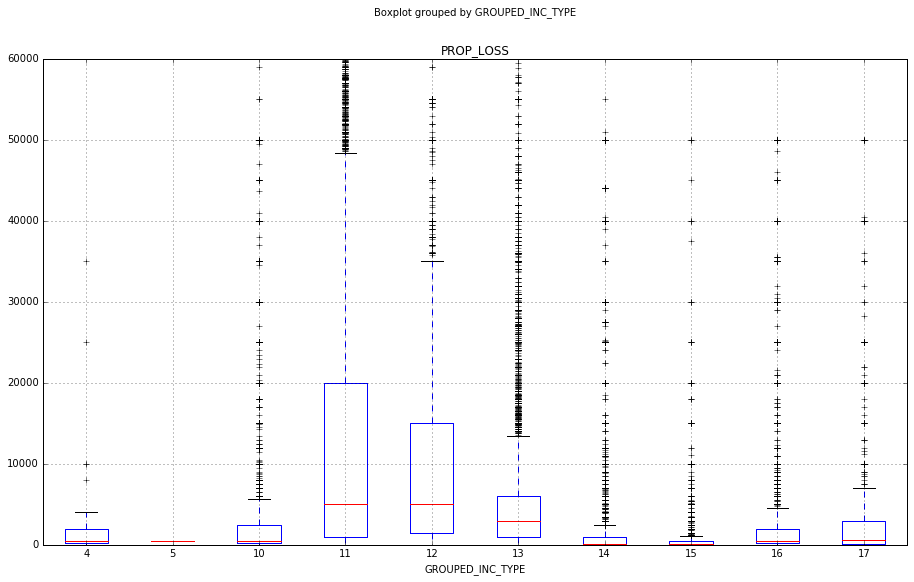

In [5]:
def map_inc_type(input_type):
    if input_type[0] == u"1":
        return int(input_type[0:2])
    else:
        return int(input_type[0])

inc_frame = frame_for('INC_TYPE')
inc_frame['GROUPED_INC_TYPE'] = inc_frame['INC_TYPE'].map(lambda x: map_inc_type(x))

plots_for(inc_frame, 'GROUPED_INC_TYPE')

Given the low levels of any kind of property damage in the 4s and 5s, we may just uninclude those groups entirely.  The rest might be ok to represent as a one-hot encoded vector, they do show differences in distribution.  Groups 11 and 12 stand out on their own, group 14 and 15 have hardly ever caused any significant damage.

# Address On Wildland

The next field (ADD_WILD) represents whether the target address is in a wildland area or not.  It's possible this could be relevant, let's take a look.


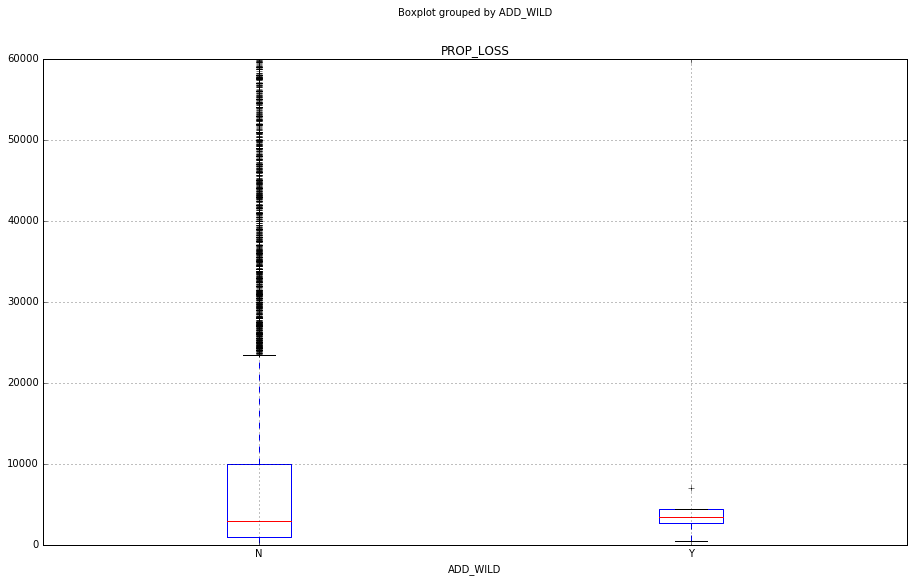

In [6]:
wildland_frame = frame_for('ADD_WILD')
plots_for(wildland_frame, 'ADD_WILD')

Indeed it looks like being in the wildland areas means that you won't expect nearly as high of a potential for property damage.  I don't believe this is because less damage occurs, but similar property sizes in a rural area are simply worth less due to value differentials.  At least I thought that was the case until I looked at the data more closely, but it turns out that there are only 31 incidents in the dataset, and only 4 of them have any property loss reported.  I don't think there's enough information gain here to be worth including as a dimension, so we'll move on.

# Aid given or received

In the fire service, there are some locations on the edge of response areas that are automatically set to request aid from a neighboring department on dispatch, and some where units will request aid from a neighboring agency in route.  I suspect there will be higher rates of damage for these addresses because there is typically less effective interunit coordination on multi-agency responses.

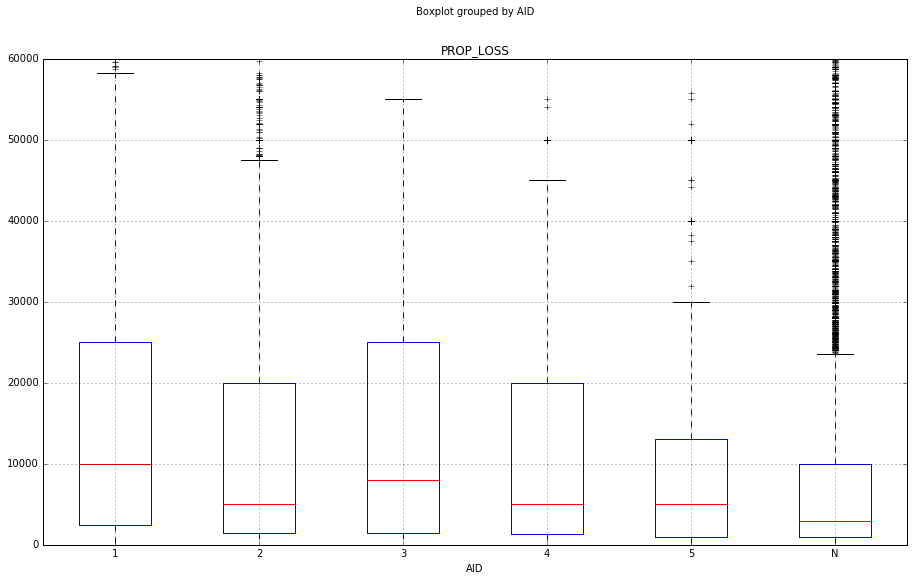

In [7]:
aid_frame = frame_for('AID')
plots_for(aid_frame, 'AID')

It certainly looks like there are some differences between categories; I might group 1 and 2 together (automatic aid, outcomes should be similar), as well as 2 and 4 (mutual requested aid so that would be 4 categories: automatic aid, mutual aid, no aid, and other aid.

# Alarm timestamp

Alone, this bit of data seems not very useful.  However, encoded within it are 3 features I think might be worth exploring: time of day, day of week, and month.  Damage may be seasonal, as winter can hinder fire response.  Incidents in the middle of the night may progress farther before being called in because the residents are asleep.  Weekdays may have empty houses due to work shchedules and may show damage increases for the same reason.  I think I'm going to build a frame that maps the timestamp to each of these features and maps them independently, then plot each one to see if differences pop out.



In [8]:
from datetime import date

alarm_frame = frame_for("ALARM")

def normalize_alarm(alarm):
    string = str(alarm)
    if len(string) == 11:
        string = "0" + string
    return string

def map_alarm_to_month(alarm):
    return int(normalize_alarm(alarm)[0:2])

def map_alarm_to_year(alarm):
    return int(normalize_alarm(alarm)[4:8])

def map_alarm_to_day_of_month(alarm):
    return int(normalize_alarm(alarm)[2:4])

def map_alarm_to_hour(alarm):
    return int(normalize_alarm(alarm)[8:10])

def map_alarm_to_minute(alarm):
    return int(normalize_alarm(alarm)[10:12])    

def map_alarm_to_day_of_week(alarm):
    return date(map_alarm_to_year(alarm), map_alarm_to_month(alarm), map_alarm_to_day_of_month(alarm)).weekday()
    

alarm_frame['MONTH'] = alarm_frame['ALARM'].map(lambda x: map_alarm_to_month(x))
alarm_frame['DAY_OF_WEEK'] = alarm_frame['ALARM'].map(lambda x: map_alarm_to_day_of_week(x))
alarm_frame['HOUR_OF_DAY'] = alarm_frame['ALARM'].map(lambda x: map_alarm_to_hour(x))

alarm_frame.head()

,ALARM,PROP_LOSS,MONTH,DAY_OF_WEEK,HOUR_OF_DAY
0,10420111151,2000,1,1,11
1,11020110913,3000,1,0,9
2,11820111559,1500,1,1,15
3,12020111507,100,1,3,15
4,12920112330,2000,1,5,23


### Month

Let's see if the month has any clear impact on property losses

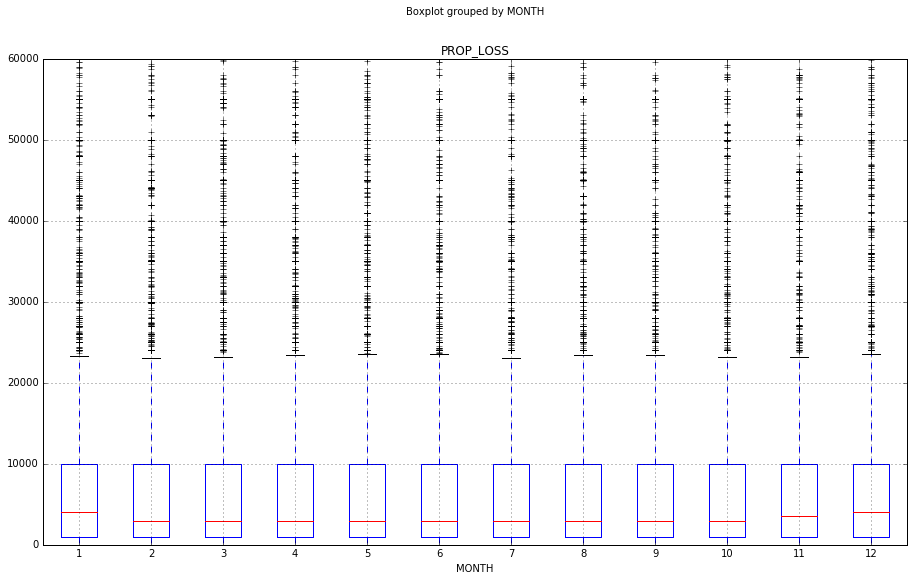

In [9]:
plots_for(alarm_frame, 'MONTH')

It looks like damages do tend to be slightly higher in months 11, 12, and 1, but I'm not sure it's significant enough to include.  The distribution looks pretty even over all.

### Day of Week

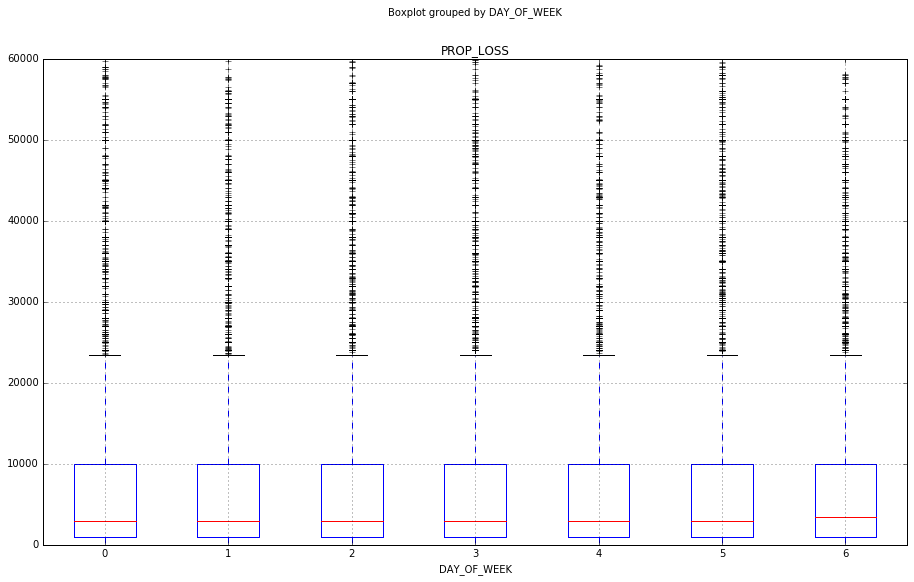

In [10]:
plots_for(alarm_frame, 'DAY_OF_WEEK')

Once again, this looks a bit too even overall to be very useful.

### Hour of Day

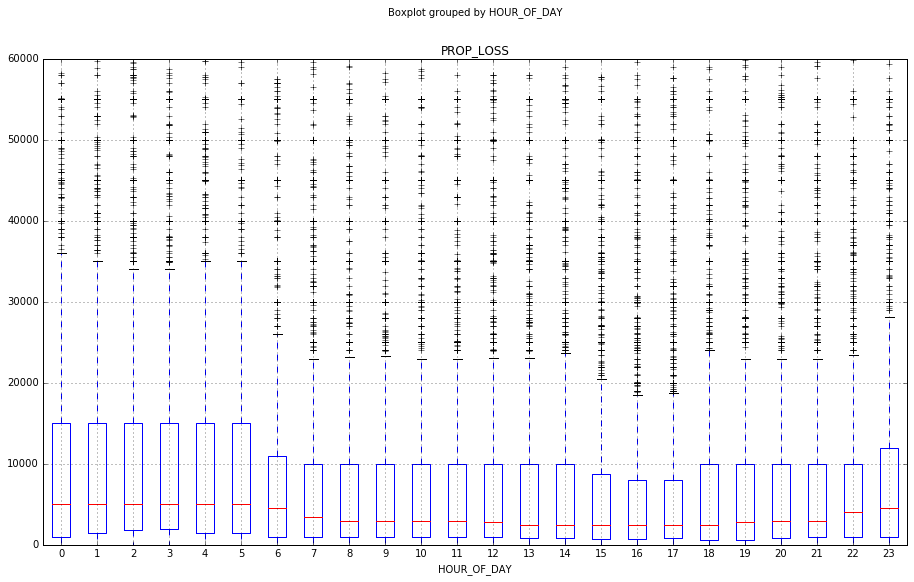

In [11]:
plots_for(alarm_frame, 'HOUR_OF_DAY')

There is a bit of a clearer trend here, hours 23-6 seem to trend higher (when folks are sleeping), whereas damages in the 15-17 range are lower.  This isn't as pronounced among outliers, but the outliers for the afternoon hours do cluster lower. I think this one is worth including, though maybe we could group them up into morning/evening, afternoon, and overnight to save on dimensions.

# Arrival Timestamp

This feature on it's own may not be that interesting, it will probably contain the same information as the alarm timestamp roughly.  However, the _difference_ between alarm and arrival of the first firefighting unit should show some interesting data, since longer response times should let the fire range longer unchecked, allowing it to spread farther and damage more.  I'm going to map this field to a delta instead.

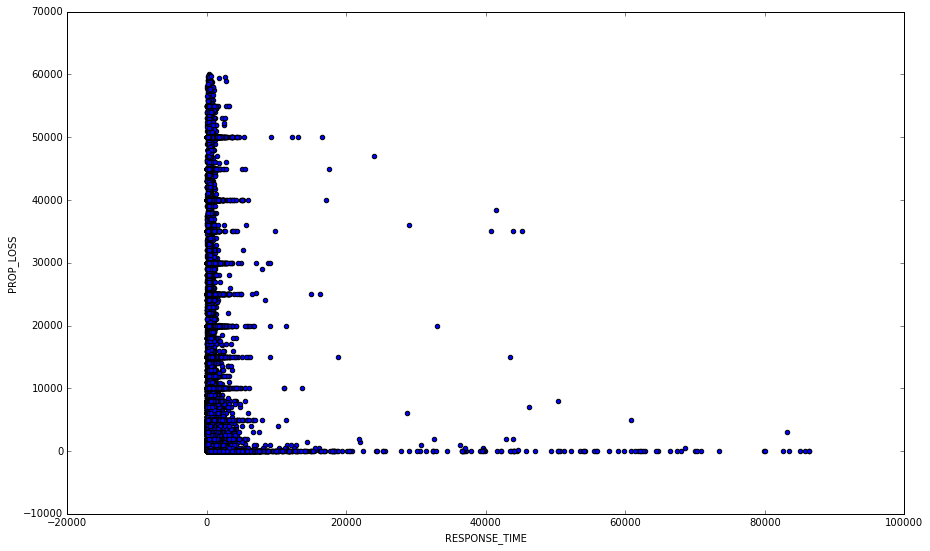

In [12]:
from datetime import datetime
arrival_frame = pd.read_sql_query("select ALARM, ARRIVAL, PROP_LOSS from incidents where PROP_LOSS IS NOT NULL", conn)
arrival_frame[['PROP_LOSS']] = arrival_frame[['PROP_LOSS']].apply(pd.to_numeric)

def ts_to_dt(ts):
    return datetime(map_alarm_to_year(ts), map_alarm_to_month(ts), map_alarm_to_day_of_month(ts),
             map_alarm_to_hour(ts), map_alarm_to_minute(ts))

arrival_frame['ALARM_TS'] = arrival_frame['ALARM'].map(lambda x: ts_to_dt(x))
arrival_frame['ARRIVAL_TS'] = arrival_frame['ARRIVAL'].map(lambda x: ts_to_dt(x))
arrival_frame['RESPONSE_TIME'] = arrival_frame['ARRIVAL_TS'] - arrival_frame['ALARM_TS']
arrival_frame['RESPONSE_TIME'] = arrival_frame['RESPONSE_TIME'].map(lambda x: x.seconds)


common_data_frame = arrival_frame[arrival_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='RESPONSE_TIME', y='PROP_LOSS', figsize=(15,9))


This is a bit unexpected.  I really thought longer response times would correlate with more property damage.  Maybe I'm still seeing too many outliers, I'm going to really zoom down to the meat of the data and see if the relationship exists in th lower ranges.

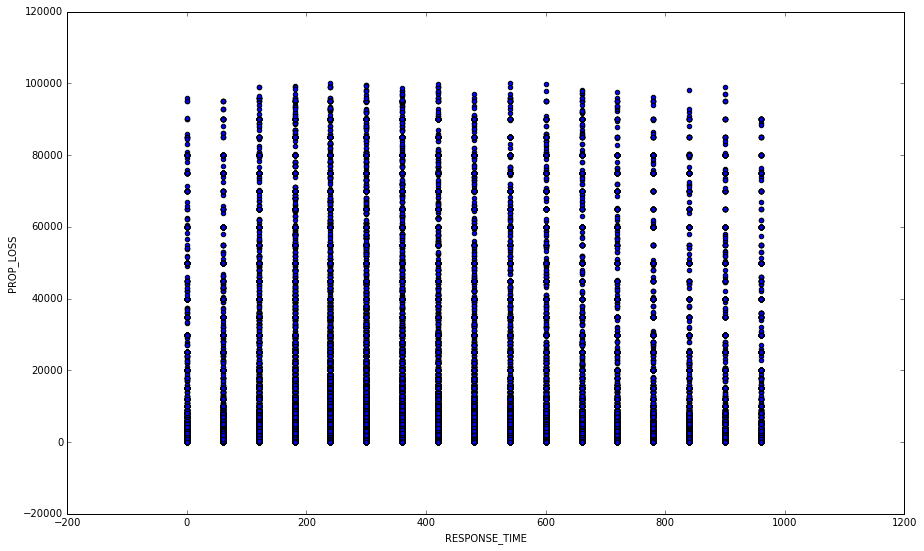

In [13]:
targeted_frame = arrival_frame[arrival_frame.PROP_LOSS < 100000]
targeted_frame = targeted_frame[targeted_frame.RESPONSE_TIME <= 1000]
targeted_frame.plot(kind='scatter', x='RESPONSE_TIME', y='PROP_LOSS', figsize=(15,9))

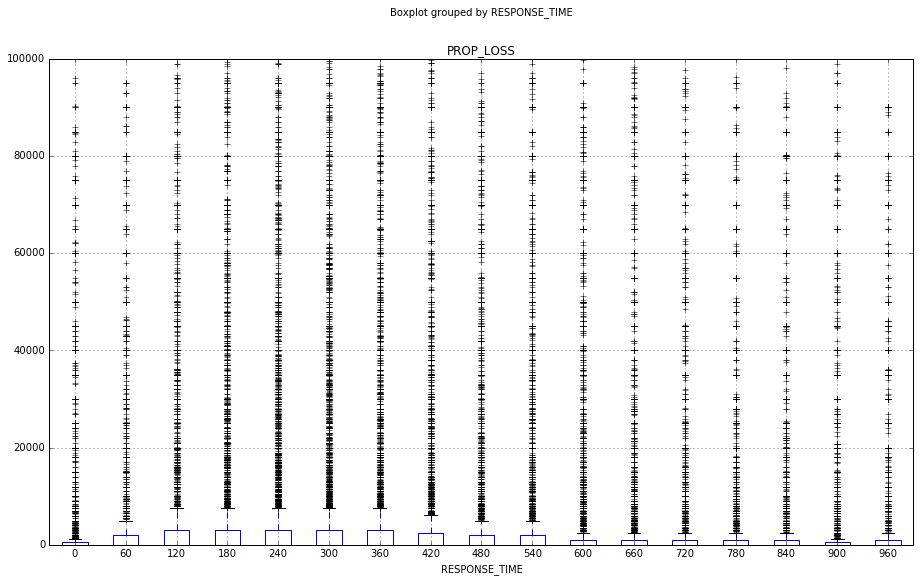

In [16]:
targeted_frame.boxplot(column="PROP_LOSS", by="RESPONSE_TIME", figsize=(15,9))

Boy, the relationship just doesn't look that significant.  Ok, I guess we're moving on for now, and probably not going to include this feature in the final data for learning.

# Incident Controlled

This is the time at which the on-scene officer declares the incident is no longer spreading and is under control.  I had similar suspicions for this field as for arrival time, though my enthusiasm is tampered now.  Let's run it through a similar process.

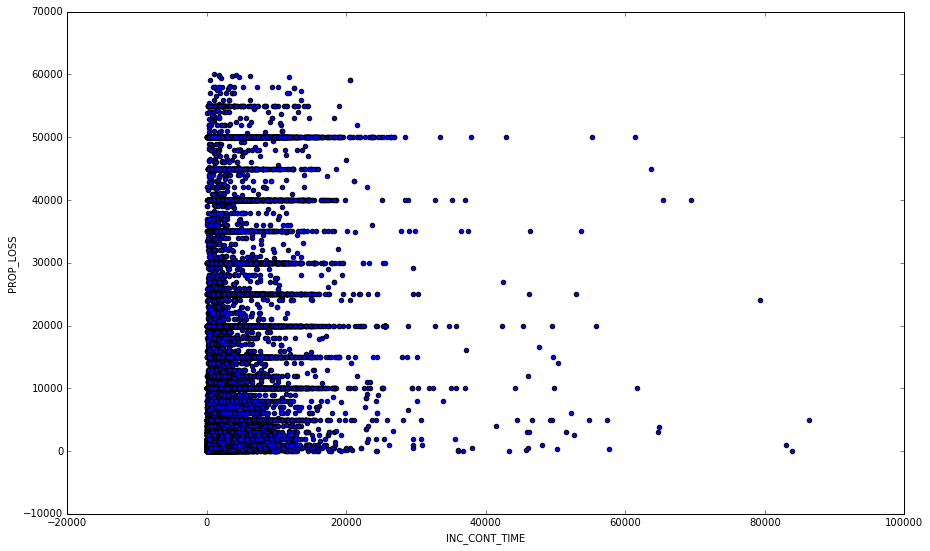

In [17]:
inc_con_frame = pd.read_sql_query("select ALARM, INC_CONT, PROP_LOSS from incidents where PROP_LOSS IS NOT NULL AND INC_CONT != 0 AND PROP_LOSS != 0", conn)
inc_con_frame[['PROP_LOSS']] = inc_con_frame[['PROP_LOSS']].apply(pd.to_numeric)

inc_con_frame['ALARM_TS'] = inc_con_frame['ALARM'].map(lambda x: ts_to_dt(x))
inc_con_frame['INC_CONT_TS'] = inc_con_frame['INC_CONT'].map(lambda x: ts_to_dt(x))
inc_con_frame['INC_CONT_TIME'] = inc_con_frame['INC_CONT_TS'] - inc_con_frame['ALARM_TS']
inc_con_frame['INC_CONT_TIME'] = inc_con_frame['INC_CONT_TIME'].map(lambda x: x.seconds)


common_data_frame = inc_con_frame[inc_con_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='INC_CONT_TIME', y='PROP_LOSS', figsize=(15,9))


Once again at first blush the relationship seems unimpressive.  Let's look at the densest part of the data:

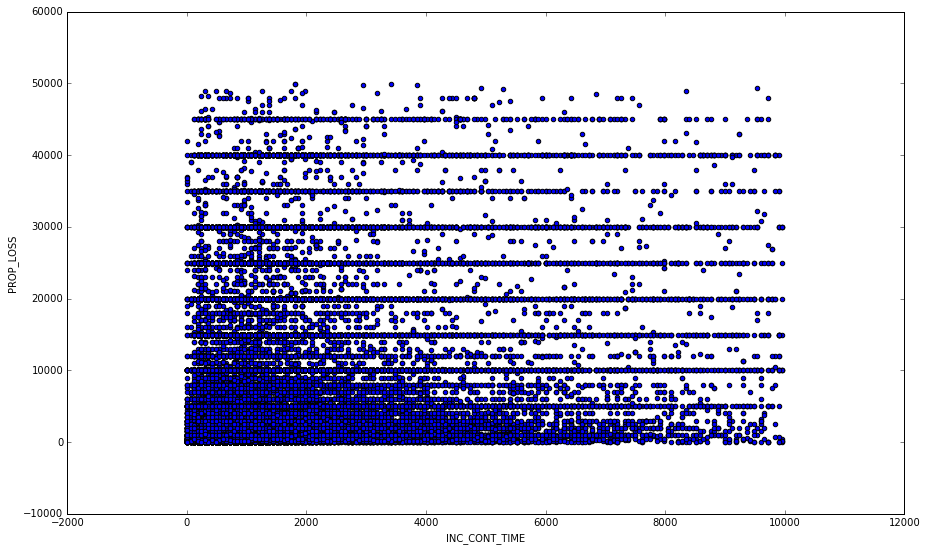

In [18]:
targeted_frame = inc_con_frame[inc_con_frame.PROP_LOSS < 50000]
targeted_frame = targeted_frame[targeted_frame.INC_CONT_TIME <= 10000]
targeted_frame.plot(kind='scatter', x='INC_CONT_TIME', y='PROP_LOSS', figsize=(15,9))

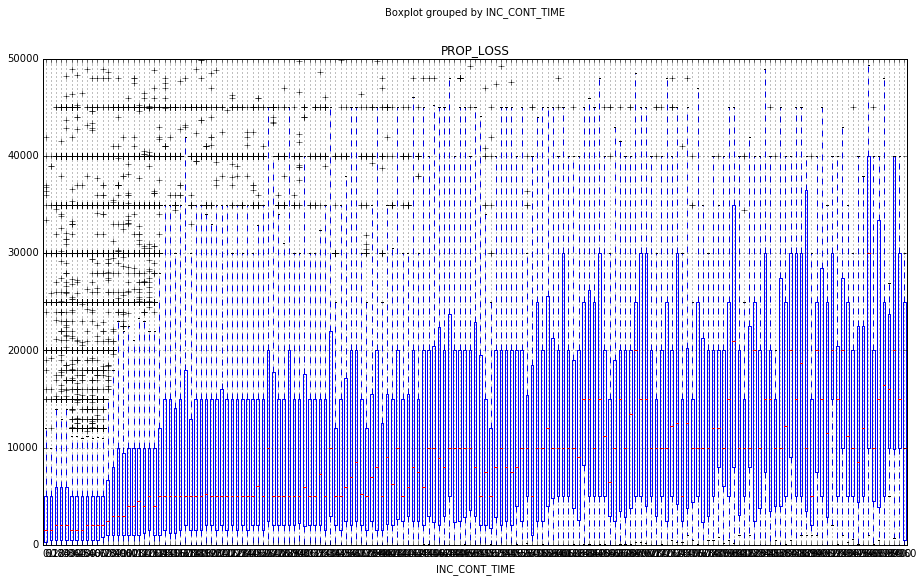

In [19]:
targeted_frame.boxplot(column="PROP_LOSS", by="INC_CONT_TIME", figsize=(15,9))

When looked at with the box plot, it does seem that there is some increasing relationship, so we should use it I think.

# Last Unit Clear

This would be the time the last unit left the scene.  If it's anything like the other 2 timestamps, there won't be much helpful here, but we should check to be sure.

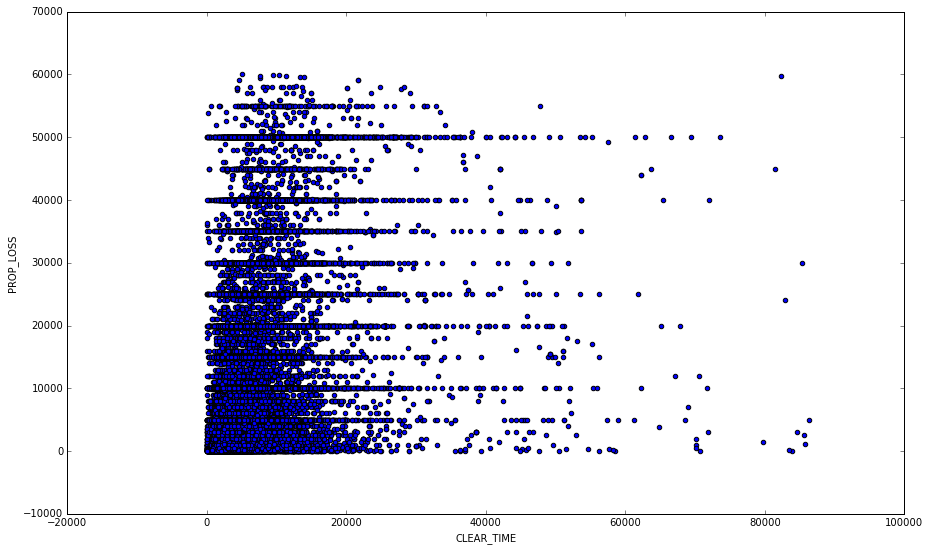

In [20]:
clear_frame = pd.read_sql_query("select ALARM, LU_CLEAR, PROP_LOSS from incidents where PROP_LOSS IS NOT NULL AND INC_CONT != 0 AND PROP_LOSS != 0", conn)
clear_frame[['PROP_LOSS']] = clear_frame[['PROP_LOSS']].apply(pd.to_numeric)

clear_frame['ALARM_TS'] = clear_frame['ALARM'].map(lambda x: ts_to_dt(x))
clear_frame['LU_CLEAR_TS'] = clear_frame['LU_CLEAR'].map(lambda x: ts_to_dt(x))
clear_frame['CLEAR_TIME'] = clear_frame['LU_CLEAR_TS'] - clear_frame['ALARM_TS']
clear_frame['CLEAR_TIME'] = clear_frame['CLEAR_TIME'].map(lambda x: x.seconds)


common_data_frame = clear_frame[clear_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='CLEAR_TIME', y='PROP_LOSS', figsize=(15,9))


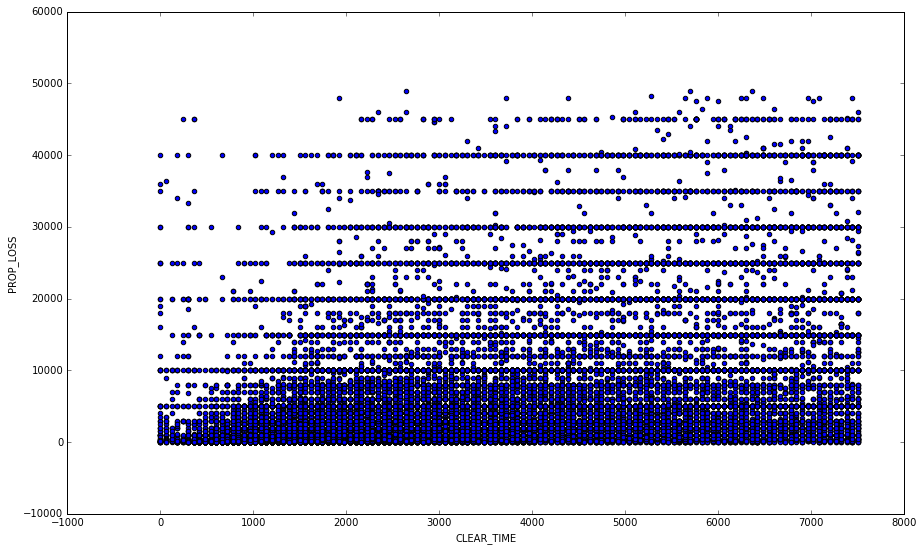

In [21]:
targeted_frame = clear_frame[clear_frame.PROP_LOSS < 50000]
targeted_frame = targeted_frame[targeted_frame.CLEAR_TIME <= 7500]
targeted_frame.plot(kind='scatter', x='CLEAR_TIME', y='PROP_LOSS', figsize=(15,9))

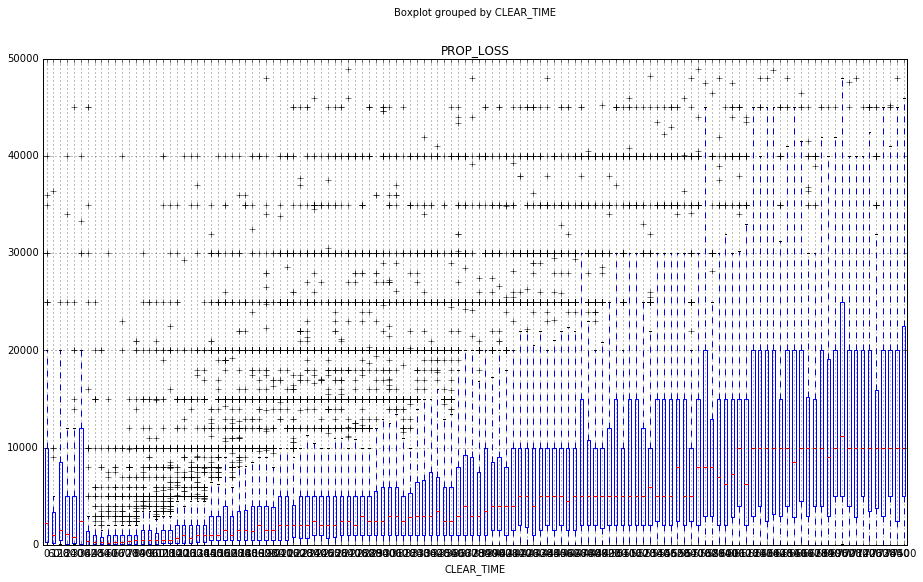

In [22]:
targeted_frame.boxplot(column="PROP_LOSS", by="CLEAR_TIME", figsize=(15,9))

hmm, it looks like there _is_ some releationoship here, an upward curve all the way through, despitethat spike int he low numbers.  It seems like we may be able to use this.

# APP_MOD

I skipped "ALARMS". These are calls for resource packages, so more alarms should mean more damage.  Unfortunately,these don't appear to be uniformly coded, so I don't know that there's much useful to extract here.

APP_MOD: Whether the organization used a package of apparatus and personnel.  I thought that those incidents with "Y" would be better organized, but it looks like it really doesn't make much difference

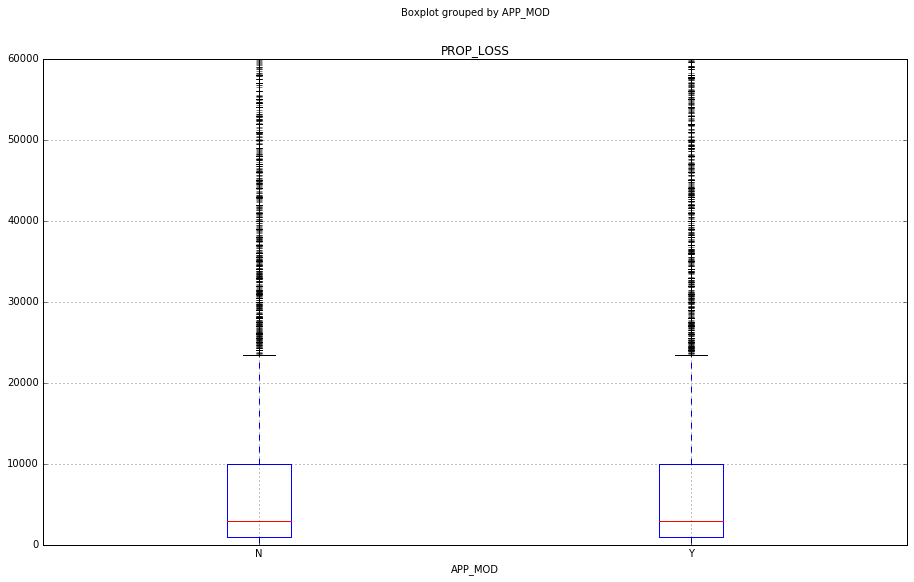

In [23]:
alarms_frame = frame_for('APP_MOD')
plots_for(alarms_frame, 'APP_MOD')

seems like we can exclude this feature.

# Suppression Apparatus

If there are more apparatus, then it should be a bigger fire, so there should be more damage.

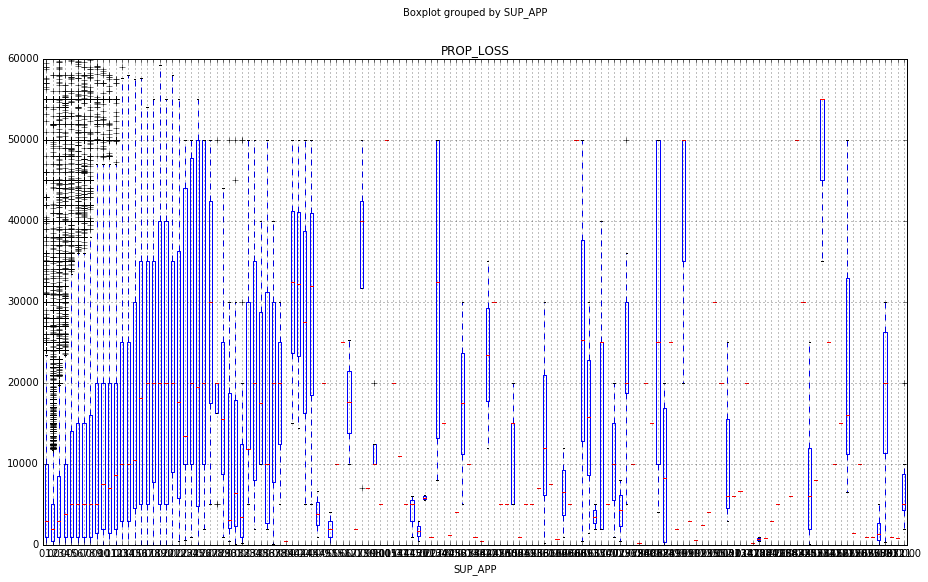

In [24]:
sup_frame = frame_for('SUP_APP')
plots_for(sup_frame, 'SUP_APP')

It sure looks like threre's a relationship here.  Let's look at thes scatterplot.

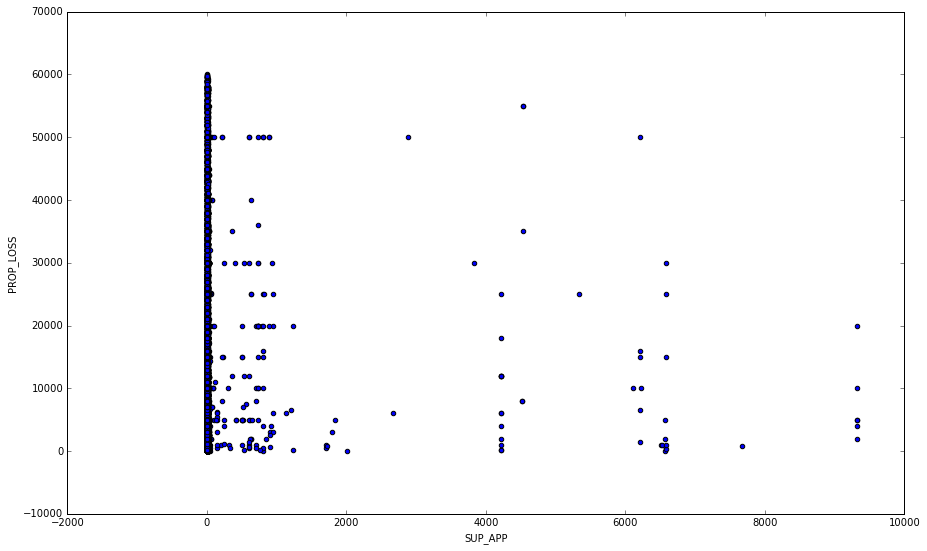

In [25]:
common_data_frame = sup_frame[sup_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='SUP_APP', y='PROP_LOSS', figsize=(15,9))

Something seems wrong here, I don't see how you could have thousands of suppression apparatus at an event, and yet there are many data points here that indicate it.  Let's restrict this down to < 40.

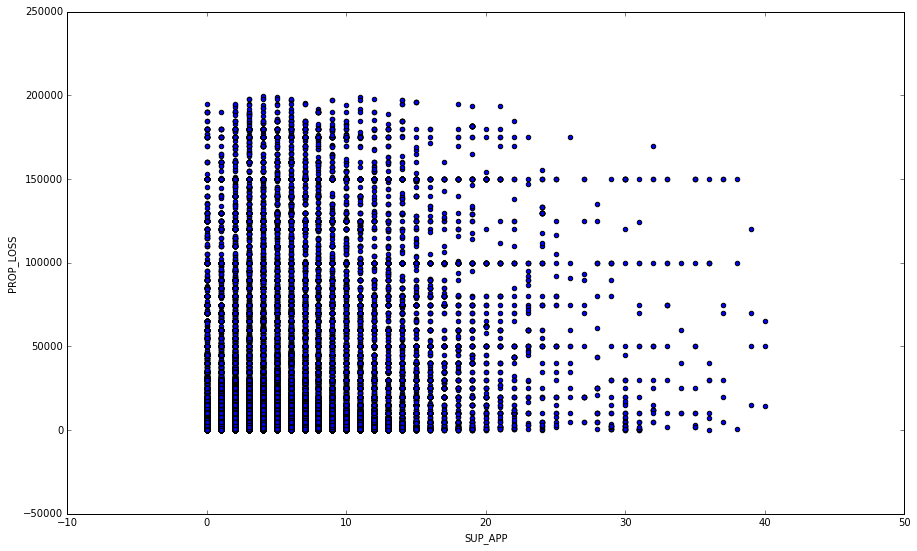

In [26]:
targeted_frame = sup_frame[sup_frame.PROP_LOSS < 200000]
targeted_frame = targeted_frame[targeted_frame.SUP_APP <= 40]
targeted_frame.plot(kind='scatter', x='SUP_APP', y='PROP_LOSS',figsize=(15,9))

Hmm, actually I don't think a scatterplot is conveying it very well at this level, let's take the targeted frame and go back to a box plot.

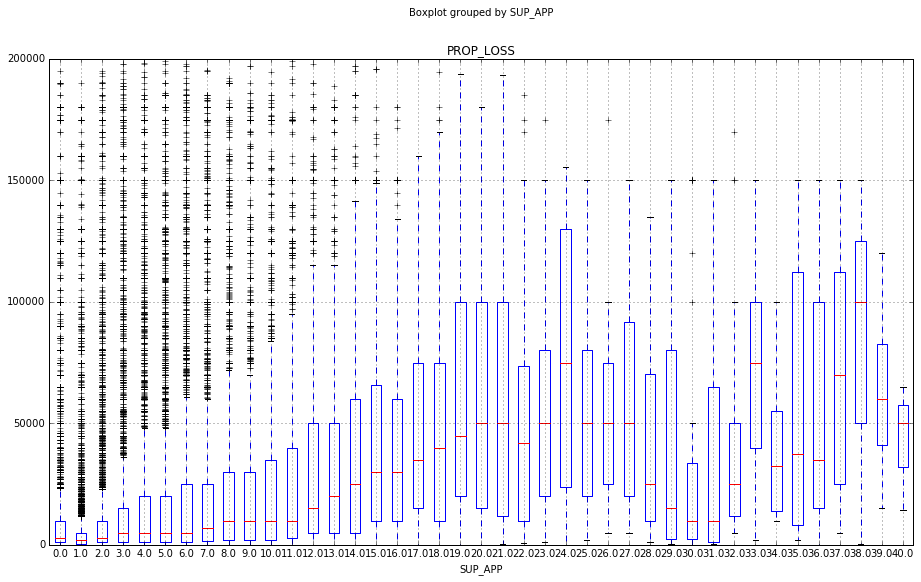

In [27]:
targeted_frame.boxplot(column="PROP_LOSS", by="SUP_APP", figsize=(15,9))

That seems to make it a bit more clear, there does seem to be an increasing relationship overall up through 20 trucks or so.  At first glance it seems like this feature is worth including (possibly with feature scaling?)

# EMS Apparatus

This is similar to suppression apparatus, but EMS apparatus are summoned for medical problems I don't expect them to correlate in the same way.  We'll see.

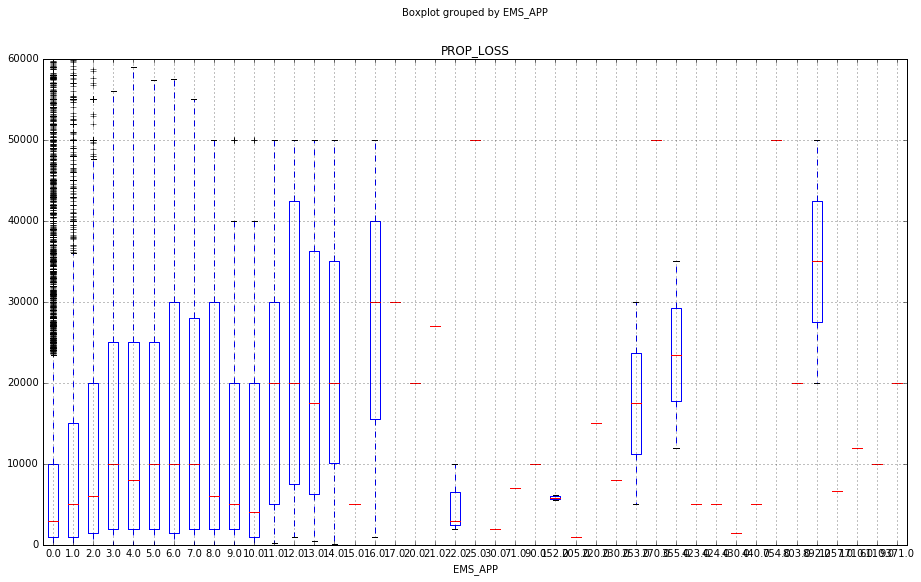

In [28]:
ems_frame = frame_for('EMS_APP')
plots_for(ems_frame, 'EMS_APP')

As I expected, this doesn't correlate quite as well, and because EMS units are typically sent to fires as part of a package response, it's really re-capturing the suppression apparatus feature in a way.  I think we can leave it out.

# Suppression Personnel

This should be scaling directly with suppression apparatus in career departments, but there are many volunteer departments that will dispatch additional personnel to a big incident without sending more trucks necessarily, so it may still be a useful feature.



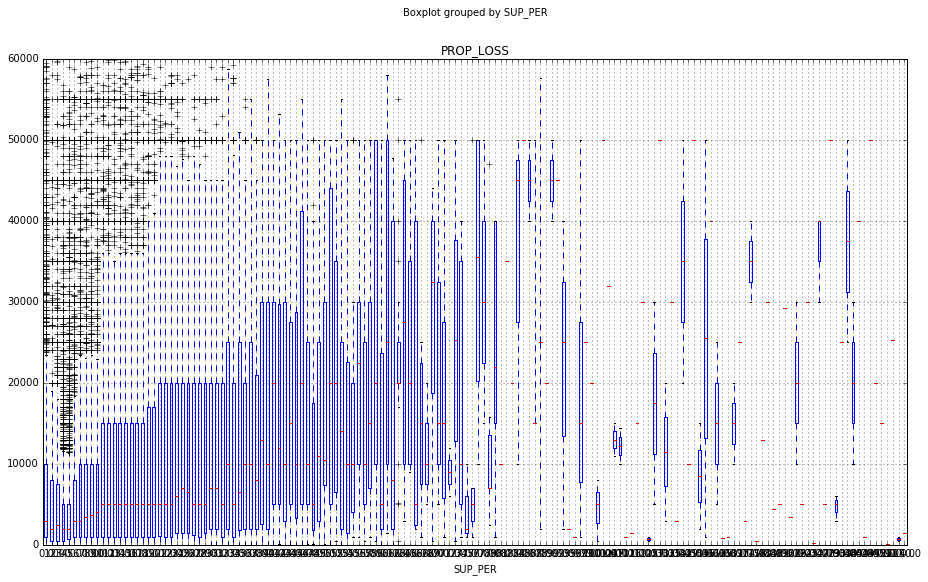

In [29]:
pers_frame = frame_for('SUP_PER')
plots_for(pers_frame, 'SUP_PER')

the relationship up seems useful here (though less predictive early on, so there are some cases like dispatch where this would not be a data point available at the time decisions are being made).  Still, I think it's worth including.  We're going to skip EMS_PERsonnel though for the same reason as ems apparatus.

# Property Value

Since you cannot lose more than the value of the property, having this information available should be very relevant to predicting loss.  Let's try a scatter plot:

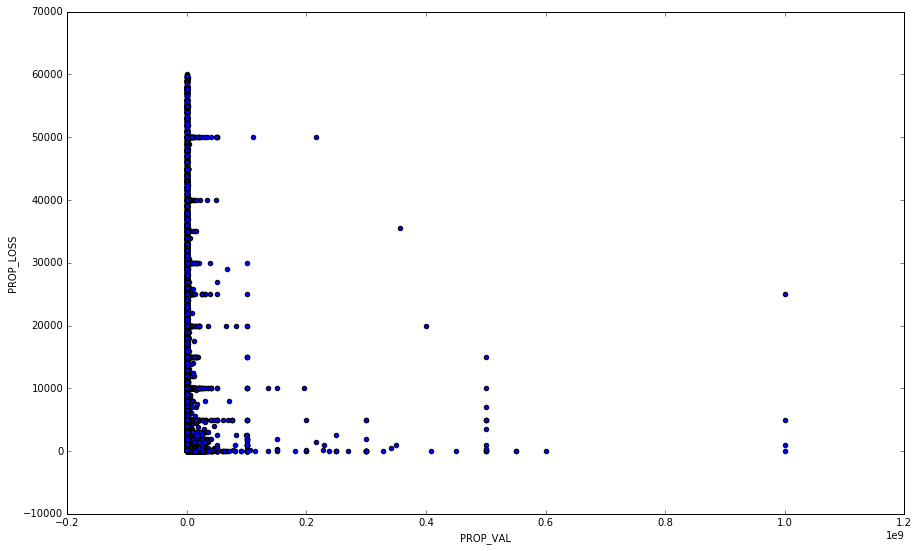

In [30]:
val_frame = pd.read_sql_query("select PROP_VAL, PROP_LOSS from incidents where PROP_LOSS IS NOT NULL AND PROP_VAL IS NOT NULL AND PROP_VAL > 0", conn)
val_frame[['PROP_LOSS']] = val_frame[['PROP_LOSS']].apply(pd.to_numeric)
val_frame[['PROP_VAL']] = val_frame[['PROP_VAL']].apply(pd.to_numeric)

common_data_frame = val_frame[val_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='PROP_VAL', y='PROP_LOSS', figsize=(15,9))

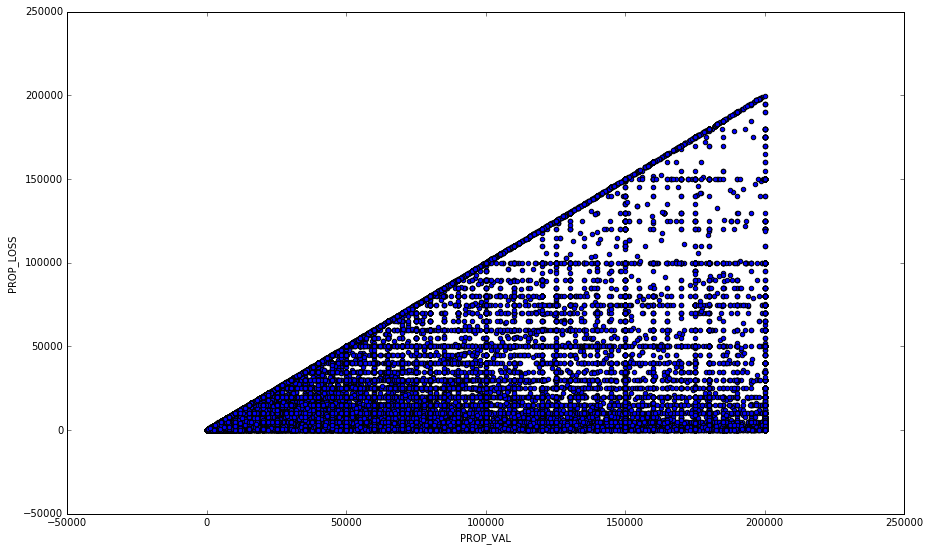

In [31]:
targeted_frame = val_frame[val_frame.PROP_LOSS < 200000]
targeted_frame = targeted_frame[targeted_frame.PROP_VAL <= 200000]
targeted_frame.plot(kind='scatter', x='PROP_VAL', y='PROP_LOSS',figsize=(15,9))

It's clear here that there are a lot of items here where the prop val and prop loss were the same (total loss), it seems like we should certainly keep this feature in.

# Detector Alert

I expect this feature to be significant; a detector alarming should start the whole response process far sooner. Let's find out.

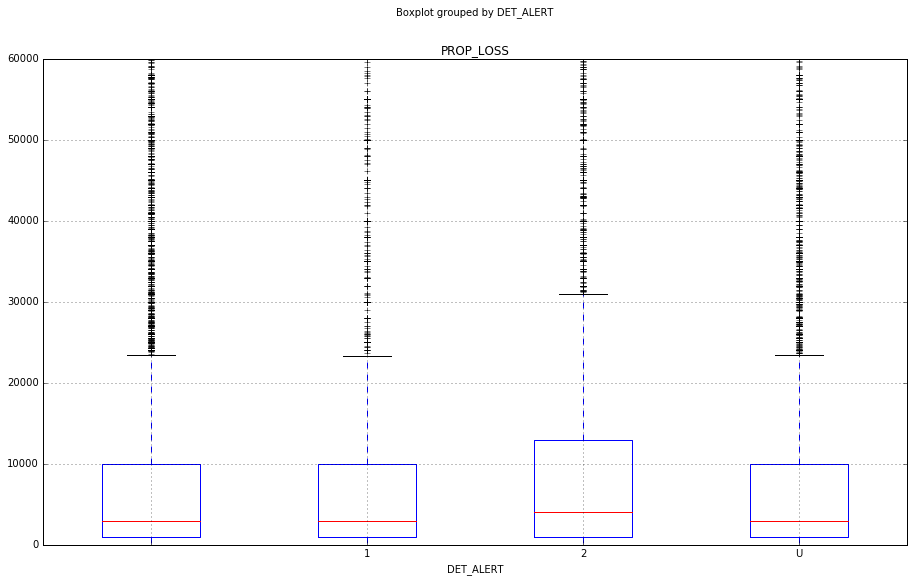

In [32]:
det_frame = frame_for('DET_ALERT')
plots_for(det_frame, 'DET_ALERT')

The "2" category is the one where the detector does not alert the occupants, and it does seem to cluster higher than the other.  I'm planning to include it, but will probably make it a single dimension (a "2" is "on", the others are "off")

# Hazardous Materials Release

structures with hazmat in them should do more damage when they go up in flames, so I expect useful information here.

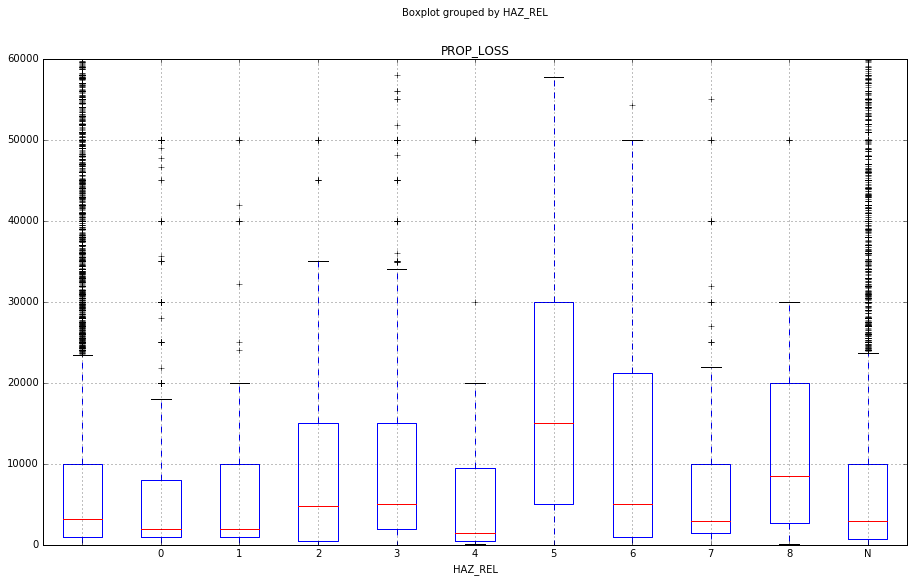

In [33]:
haz_frame = frame_for('HAZ_REL')
plots_for(haz_frame, 'HAZ_REL')

There are a few categories that stand out here; 2,3,5, and 8 (Propane, Gasoline, Diesel, Paint).  A second category might be 1, 4, and 7 (Nat Gas, Kerosine, Motor Oil), and then N and Blank could go together. 3 categories I guess.  5 may stand out enough to be on it's own actually.

# Mixed Use Type

I expect that structures that are residential are built to looser codes and almost never have fire suppression systems
in them.  They'll probably stand out.  Not sure about the rest

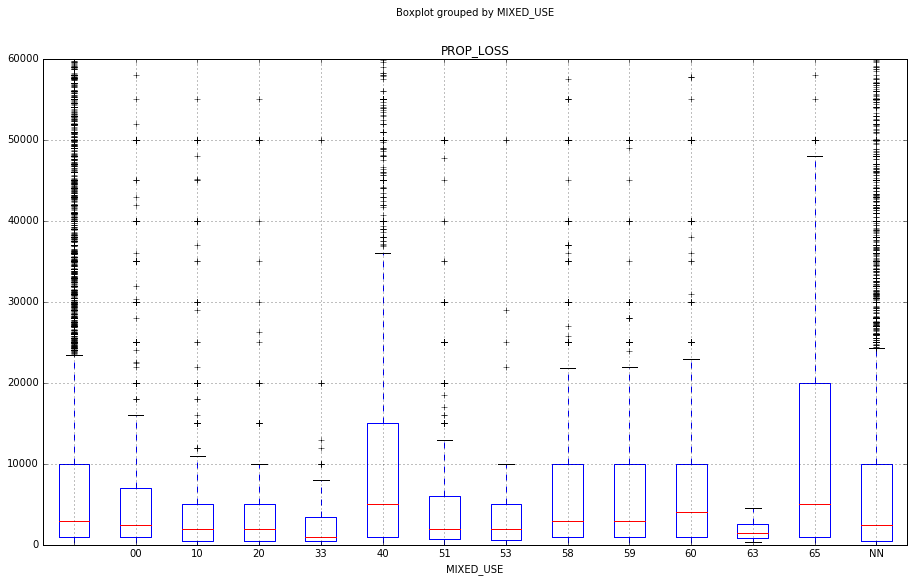

In [34]:
mu_frame = frame_for('MIXED_USE')
plots_for(mu_frame, 'MIXED_USE')

So I can see here that 40 (residential)and 65 (farm) mixed use are the clear standouts.  NN also has data up and down the chart (which is "not mixed use"). Looking at all 3 plots above, 58, 59, and 60 also stand above the rest (Business, Office, Industrial) and could probably be a category. There are also a few that are reliably low (33, 63) which are Medical, and Military respectively.  There's another grouping of simliar numbers in (10, 51, 53) which are (assembly, strip mall, enclosed mall).  Looks like we can reduce this to fewer categories and still keep most of the information.

# Property Use

Like Mixed Use, I expect this to be a valuable data point, but like the incident type there are too many categories to encode successfully.  I think I'm going to take a similar approach and group them up by their lexical heirarchy since codes that start with "8" for example are all in a similar category.

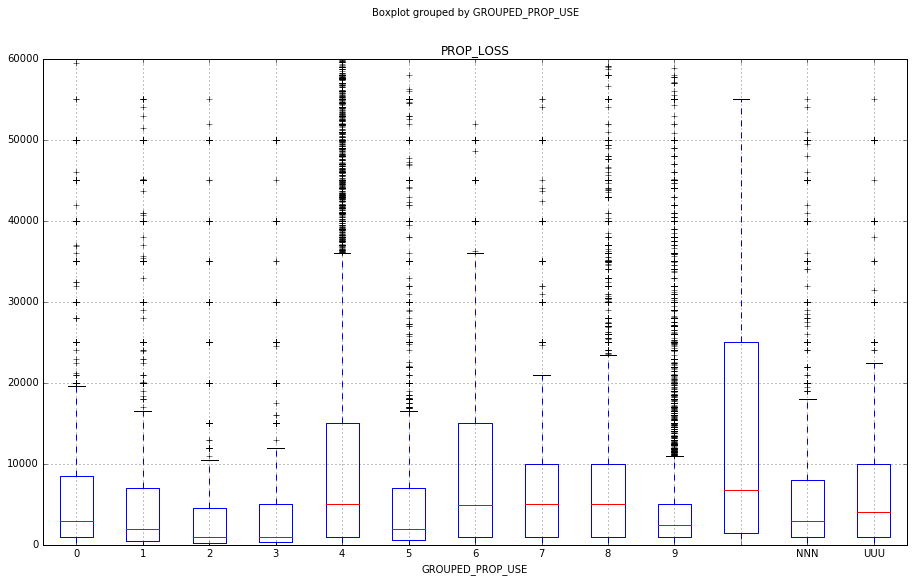

In [35]:
def map_prop_use(input_type):
    if input_type is None or len(input_type) == 0 or input_type[0] in ['U', 'N', 'u']:
        return input_type
    return int(input_type[0])

prop_frame = frame_for('PROP_USE')
prop_frame['GROUPED_PROP_USE'] = prop_frame['PROP_USE'].map(lambda x: map_prop_use(x))

plots_for(prop_frame, 'GROUPED_PROP_USE')

This definitely reduces it a bit, but it looks like we can do more.  4 (residential) ad 6 (Utility) together; 7 (manufacturing) and 8 (Storage) could be combined.  NNN, UUU, and Blank should probably go together. 0 (general), 1 (Assembly), 2 (Educational), 3(Health Care/Detention), seem to have similar patterns.  That looks like several dimensions we could reduce to and be still useful.

# Number of Units

More units in a building means a bigger building, which should result in more potential property damage (though it's also more compartmenatlization inside the structure which should help limit fire spread).  It's at least worth investigating.

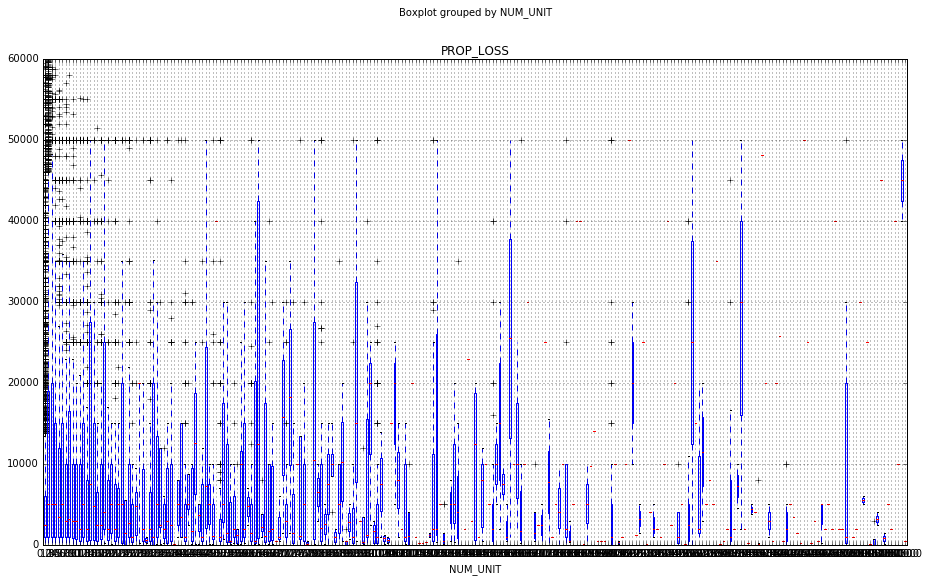

In [36]:

nu_frame = frame_for('NUM_UNIT')
plots_for(nu_frame, 'NUM_UNIT')

Well, it does look like these cluster higher when there are more units.  Let's see the scatter plot for the densest data:

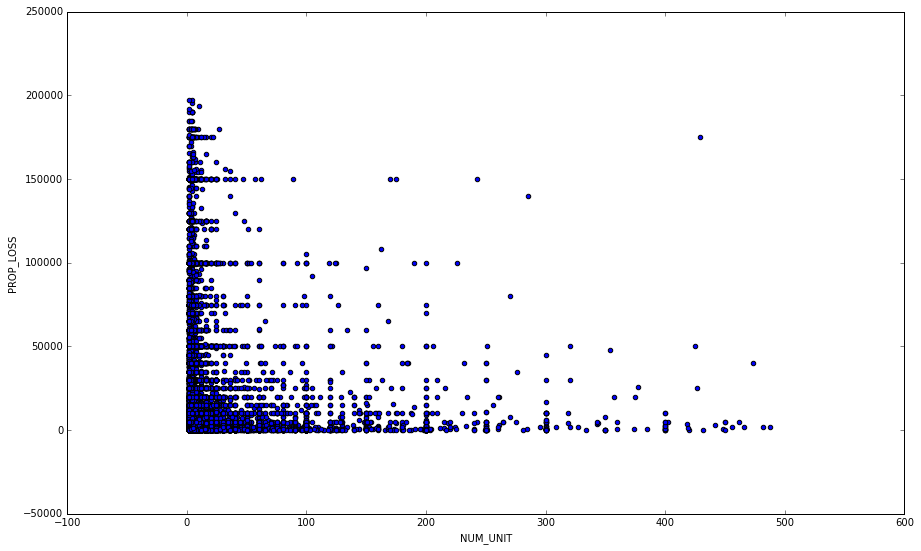

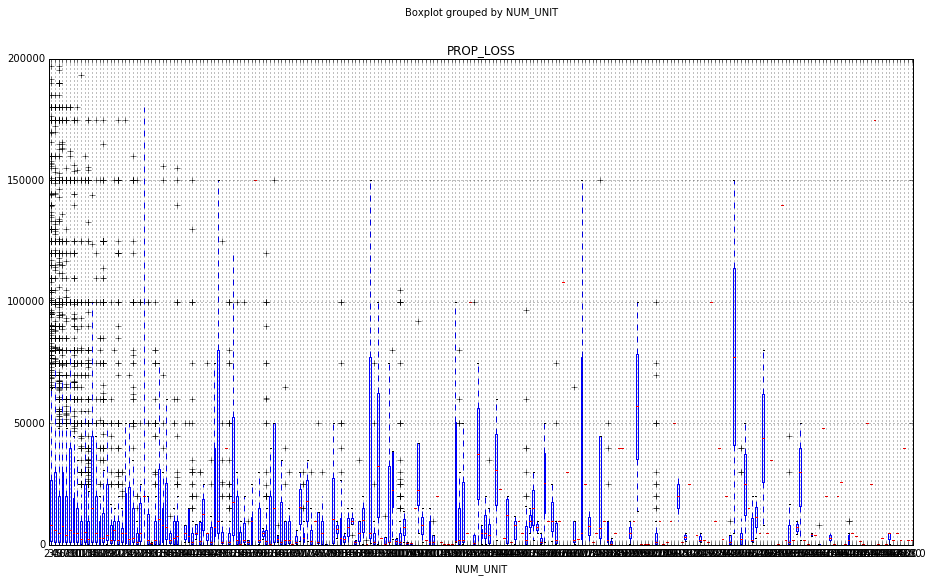

In [37]:
targeted_frame = nu_frame[nu_frame.PROP_LOSS < 200000]
targeted_frame = targeted_frame[targeted_frame.NUM_UNIT > 1]
targeted_frame = targeted_frame[targeted_frame.NUM_UNIT < 500]
targeted_frame.plot(kind='scatter', x='NUM_UNIT', y='PROP_LOSS',figsize=(15,9))
targeted_frame.boxplot(column="PROP_LOSS", by='NUM_UNIT', figsize=(15,9))

Although the relationship is there, I think it's just recommunicating some information that's already in the dataset around size and location, number of apparatus dispatched, etc, and it's not really as reliable of a pattern it seems.  I think we'd be best to leave this datapoint out.

# Not Residential

This is interesting, residential should certainly be higher due to worse fire systems.

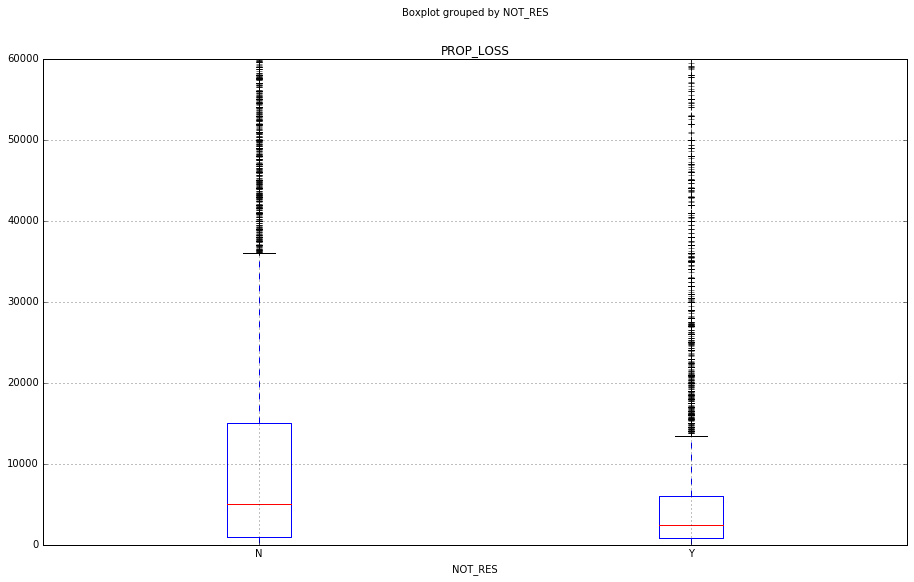

In [38]:
res_frame = frame_for('NOT_RES')
plots_for(res_frame, 'NOT_RES')

The problem here is that we already have this data in the Property Use and Mixed Use fields; the counter argument is those don't always get filled out.  It's only one dimension, I think it may be worth keeping for those data points that didn't fill in the detailed codes.

# Buildings Involved

Worth exploring, as more buildings might have more potential for property loss.

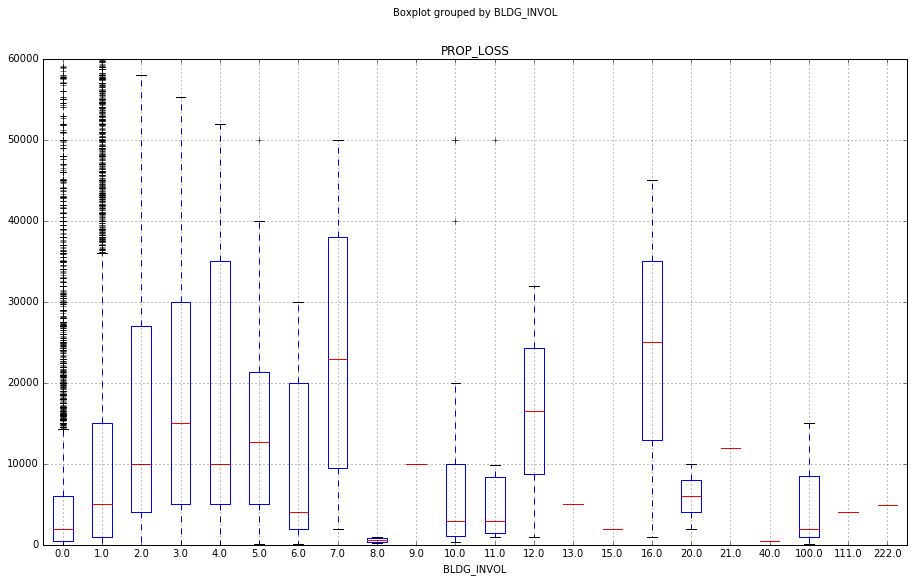

In [39]:
bld_frame = frame_for('BLDG_INVOL')
plots_for(bld_frame, 'BLDG_INVOL')

eh, actually the relationship seems a bit weak, especially in that 9-15 bulding range.  I don't think this one is too useful.

# Area of Origin

This could be significant.  A fire that starts in a garage would spread differently than one that starts in a closet.  Once again it's drastically over-coded, we'll need to reduce to more granular categories.

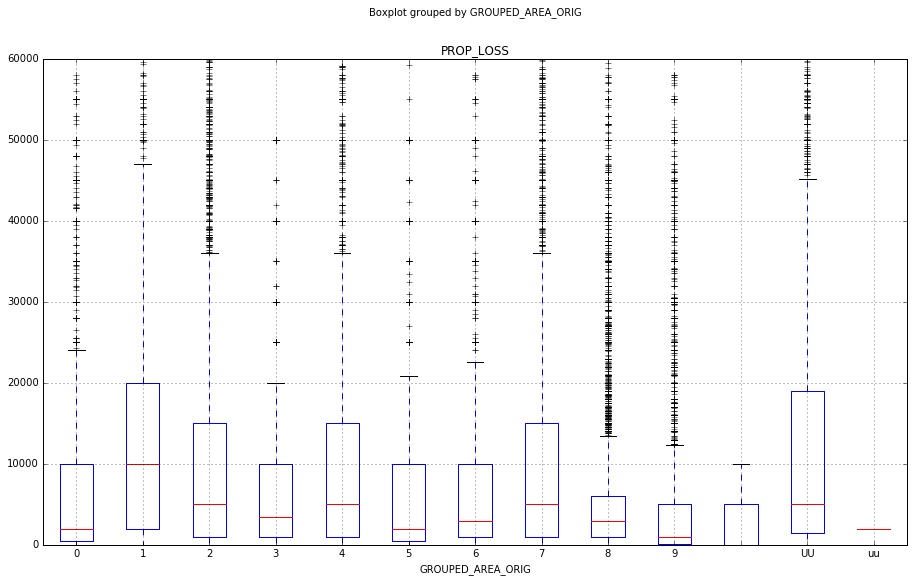

In [40]:
ao_frame = frame_for('AREA_ORIG')
ao_frame['GROUPED_AREA_ORIG'] = ao_frame['AREA_ORIG'].map(lambda x: map_prop_use(x))

plots_for(ao_frame, 'GROUPED_AREA_ORIG')

This is another case where it seems we have some clear tiers.  1, 2, 4 and 7 (Assembly, Functional, Storage and Structural areas) seem to create the most damage and have similar distributions.  3, 5,  6 seem to group together (Technical, Service, and Equipment areas), and then 0, 9, blank, UU and uu could be the grab bag of leftovers.  Seems to reduce to a few categories.

# Heat Source

This is another over-coded feature that should be relevant. A fire that starts from some kind of intense source like another fire should do more damage faster than something started by accidental arcing.

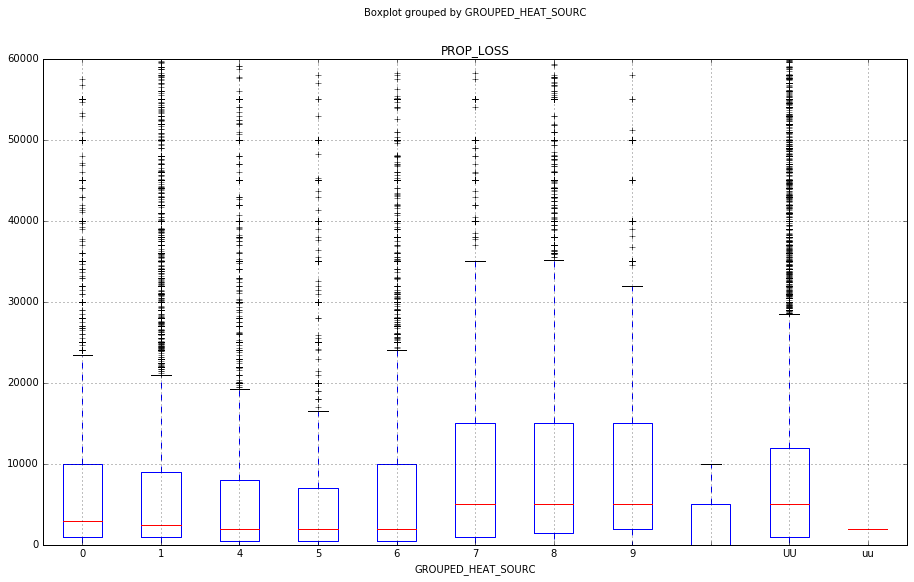

In [41]:
hs_frame = frame_for('HEAT_SOURC')
hs_frame['GROUPED_HEAT_SOURC'] = hs_frame['HEAT_SOURC'].map(lambda x: map_prop_use(x))
plots_for(hs_frame, 'GROUPED_HEAT_SOURC')

7, 8 and 9 could be one grouping, then 0,1,4,5,6 could go together, and all the blanks. 3 dimensions, and it seems like there will be some interesting info there.

# Cause of Ignition

Certainly this one seems like it should be relevant, an equipment failure will almost automatically do a great deal of damage in the process; an intentional fire set is often amatuerish and doesn't do much damage.

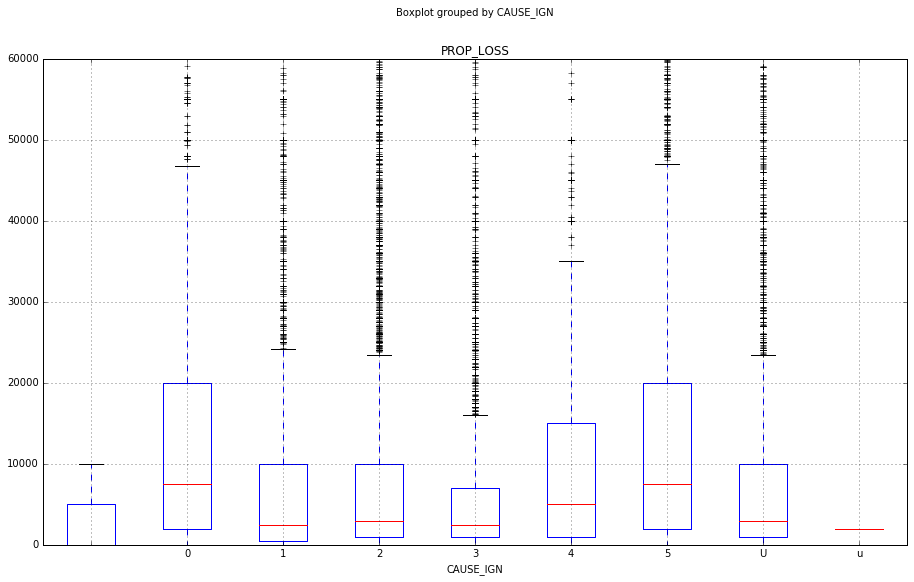

In [42]:
co_frame = frame_for('CAUSE_IGN')
plots_for(co_frame, 'CAUSE_IGN')

Indeed, there's valuable info here, and few enough categories that I think we can almost leave the data as is (though we should group "U" and "u" into a single category).

# Fire Spread

This feature just describes how far the fire has gone, which should naturally have a strong relationship since fires that have not spread very far should not do much damage.

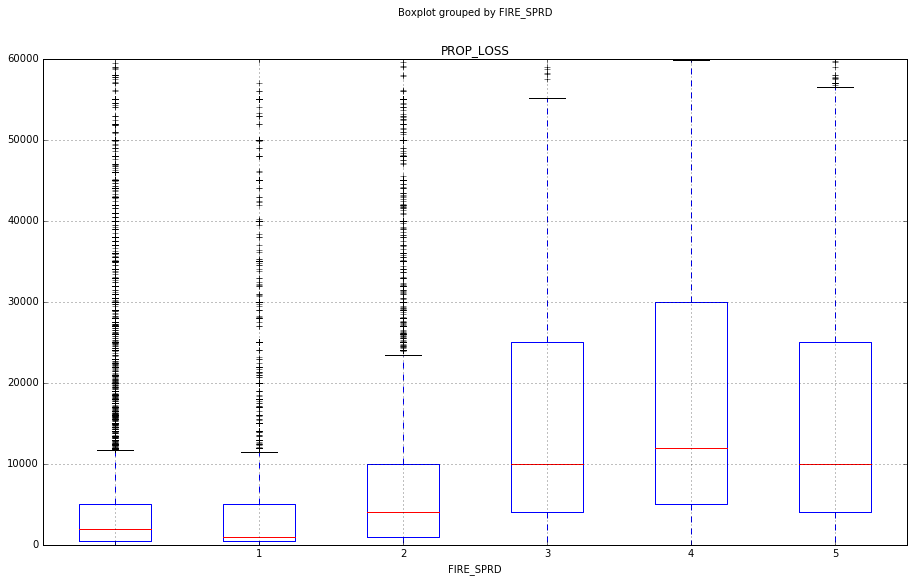

In [43]:
fs_frame = frame_for('FIRE_SPRD')
plots_for(fs_frame, 'FIRE_SPRD')

As expected, I think I'm just going to use this feature as is.

# Structure Type

Almost guaranteed to be useful, a tent will burn differently then an enclosed building.

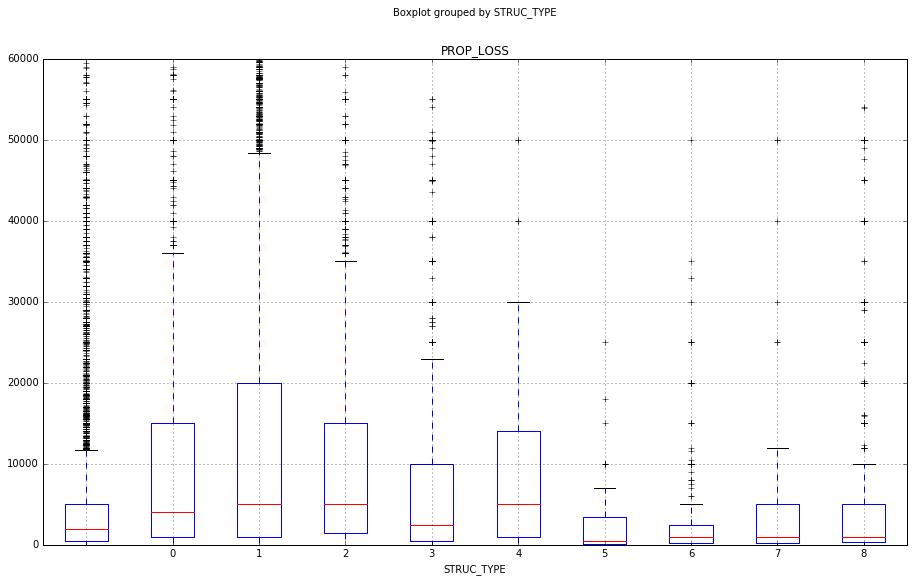

In [44]:
fs_frame = frame_for('STRUC_TYPE')
plots_for(fs_frame, 'STRUC_TYPE')

Here it seems like 5-8 could just be grouped; same with 0 and blank; the others are different enough they should probably stand on their own; so that's a 6 unit one-hot vector.

# Structural Status

I expect that vacant structures will more fully burn; but they also aren't worth as much.  I'm not sure how this one will turn out.

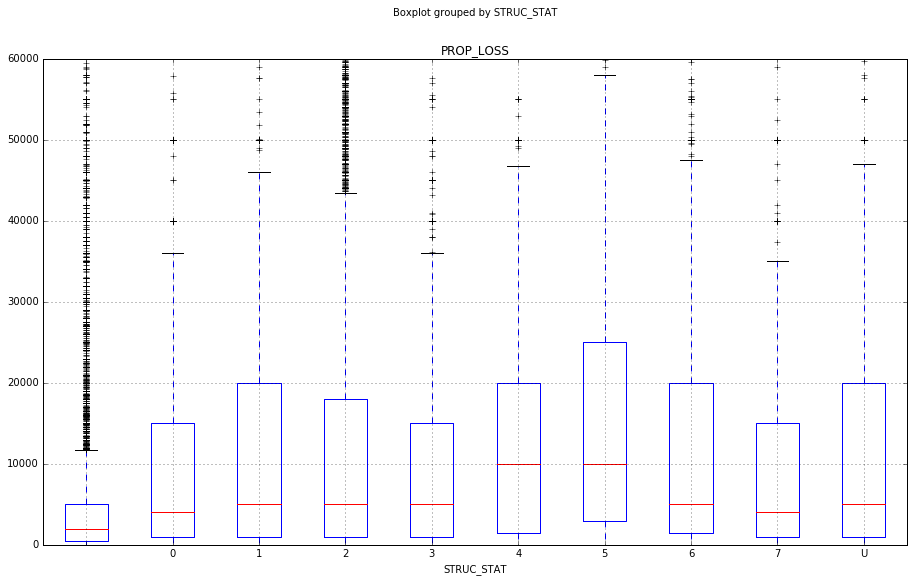

In [45]:
ss_frame = frame_for('STRUC_STAT')
plots_for(ss_frame, 'STRUC_STAT')

it looks like 1,4, and 6 might be a group.  5 should be on it's own.  U can merge into blank. 0,3, and 7 could go together.  2 has a lot of density farther up and should probably be on it's own.

# Total Square Feet

Building size should be similar to value.  Larger sizes should be more value to potentially lose.

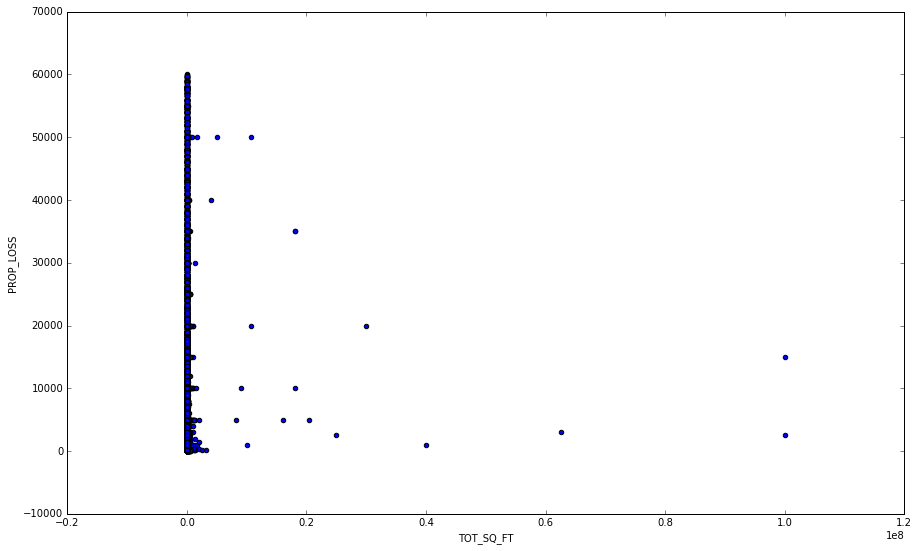

In [46]:
size_frame = frame_for('TOT_SQ_FT')
size_frame[['TOT_SQ_FT']] = size_frame[['TOT_SQ_FT']].apply(pd.to_numeric)

common_data_frame = size_frame[size_frame.PROP_LOSS < common_points_threshold]
common_data_frame.plot(kind='scatter', x='TOT_SQ_FT', y='PROP_LOSS', figsize=(15,9))

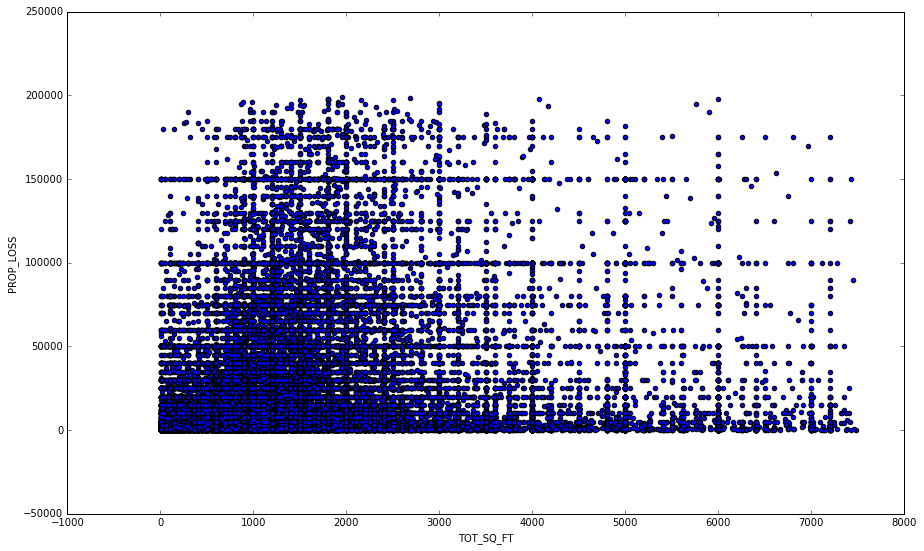

In [47]:
targeted_frame = size_frame[size_frame.PROP_LOSS < 200000]
targeted_frame = targeted_frame[targeted_frame.PROP_LOSS > 0]
targeted_frame = targeted_frame[targeted_frame.TOT_SQ_FT > 1]
targeted_frame = targeted_frame[targeted_frame.TOT_SQ_FT < 7500]
targeted_frame.plot(kind='scatter', x='TOT_SQ_FT', y='PROP_LOSS',figsize=(15,9))

Certainly among the 0 - 2000 range, there seems to be a relationship.  We'll keep the feature in for now.

# AES present

An automatic extinguishing system should have a big impact on overall damages, since fires should not be able to spread beyond the compartment of origin. Water damage should be less expensive to the structure overall.

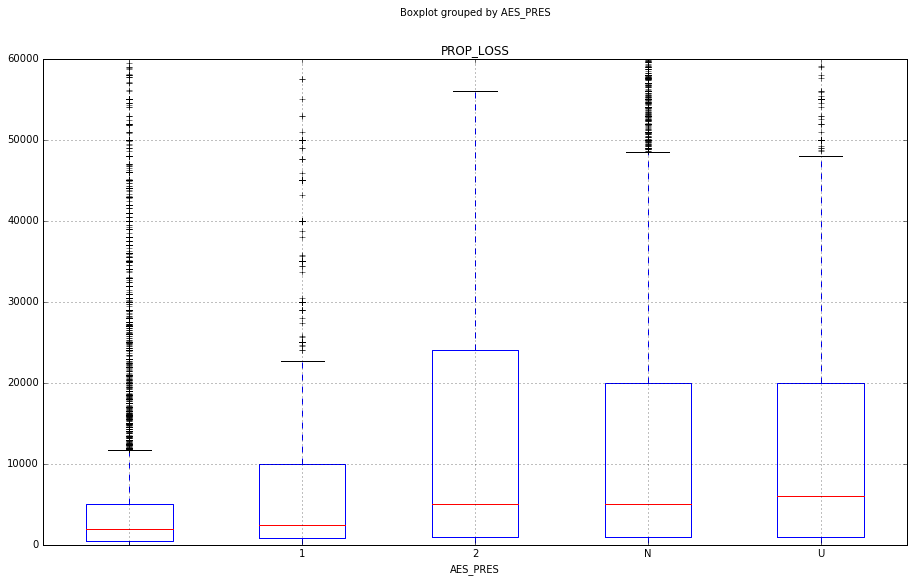

In [48]:
ap_frame = frame_for('AES_PRES')
plots_for(ap_frame, 'AES_PRES')

Indeed, those with full systems (1) have less damage than those with partial systems (2) and both have less damage than those with no systems (N).  We should just use this one as is.